In [1]:
path = r'C:\Users\duran\Python Projects\predict.csv'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

import xgboost as xgb


In [3]:
pub_df = pd.read_csv(path)

# Data exploration

In [4]:
pub_df.describe()

,recency,topic_rank,diversity,authors_mean_rank,authors_mean_hindex,authors_mean_gindex,authors_mean_sociality,authors_mean_pagerank,authors_mean_productivity,journal_pagerank,journal_rank,title_len,abstract_len,n_authors,c5,log_authors_mean_sociality
count,479.000000,479.000000,479.000000,473.000000,473.000000,473.000000,473.000000,0.0,0.0,0.0,440.000000,479.000000,479.000000,479.000000,479.000000,473.000000
mean,13.419624,10.125261,-0.675481,741.769615,0.844051,0.844668,3.411132,NaN,NaN,NaN,146.184091,94.983299,1162.283925,4.369520,6.713987,1.264066
std,5.860415,5.748655,0.606013,581.948922,0.363961,0.364351,2.790555,NaN,NaN,NaN,111.398299,38.524238,657.597003,2.800775,12.547968,0.703466
min,5.000000,1.000000,-2.995732,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,16.000000,0.000000,1.000000,0.000000,0.000000
25%,8.000000,5.000000,-1.087146,265.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,53.750000,68.000000,758.500000,2.000000,0.000000,0.693147
50%,13.000000,10.000000,-0.526332,596.000000,1.000000,1.000000,3.000000,NaN,NaN,NaN,122.000000,91.000000,1197.000000,4.000000,2.000000,1.386294
75%,18.000000,15.000000,-0.150066,1141.000000,1.000000,1.000000,5.000000,NaN,NaN,NaN,216.750000,116.500000,1587.500000,6.000000,8.000000,1.791759
max,25.000000,20.000000,-0.056685,2336.000000,1.125000,1.166667,15.000000,NaN,NaN,NaN,436.000000,279.000000,3655.000000,16.000000,154.000000,2.772589


drop columns that contains only "NaN"

In [5]:
pub_df = pub_df.drop(['authors_mean_pagerank', 'authors_mean_productivity', 'journal_pagerank'], axis = 1)

explore dependence between response and explanatory variables

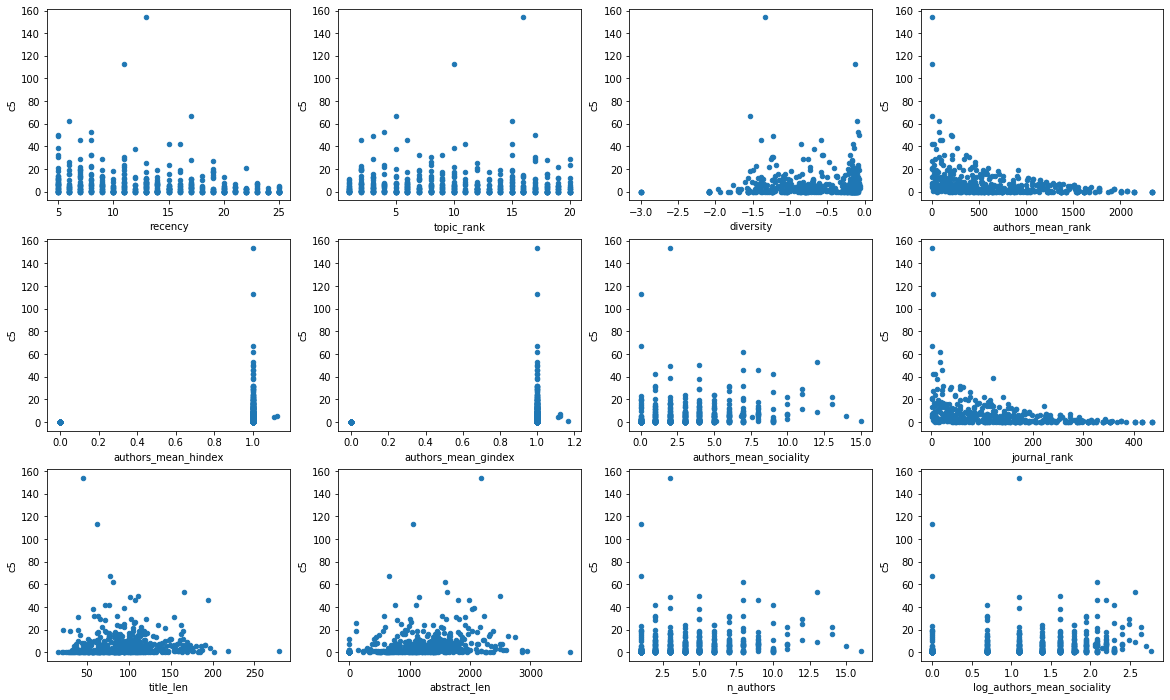

In [6]:
n_rows = 3 
n_cols = 4
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 12))
for idx, feature in enumerate(pub_df.columns[pub_df.columns != 'c5']):
    pub_df.plot(feature, "c5", subplots=True,kind="scatter",ax=axes[idx // 4,idx % 4])

explore correlation between all features

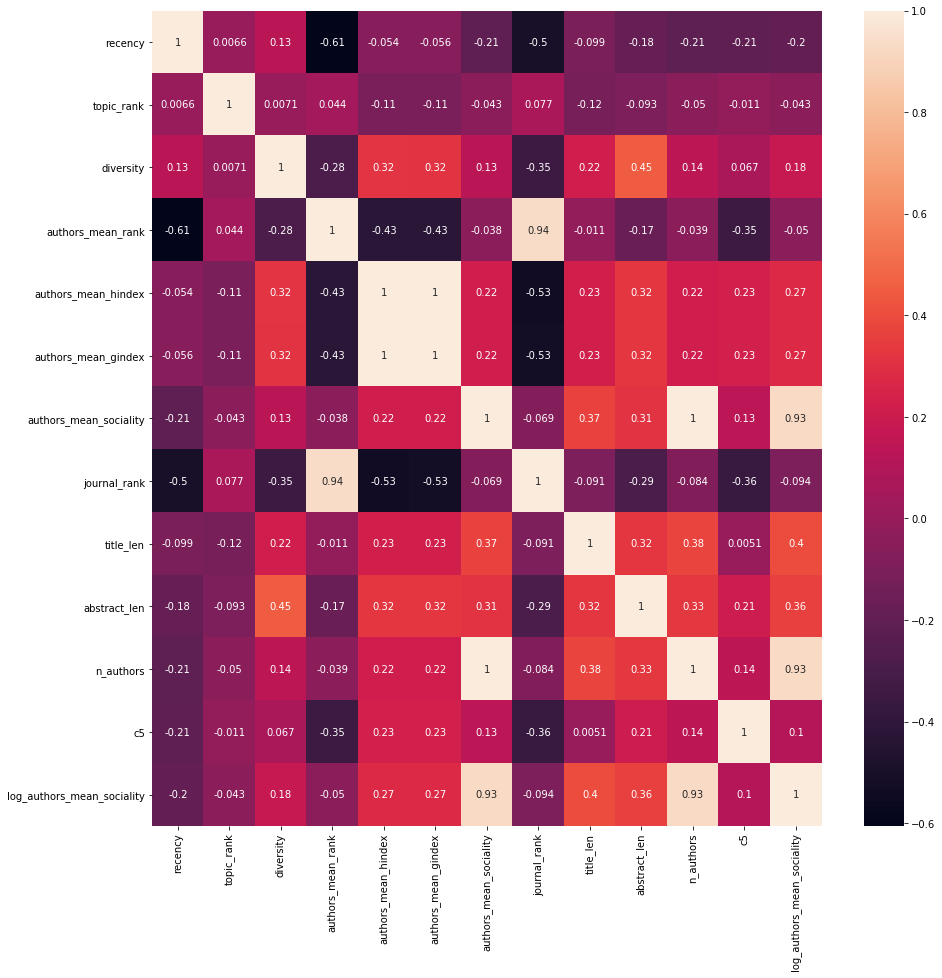

In [7]:
plt.figure(figsize = (15, 15))
hm = sns.heatmap(pub_df.corr(),
                cbar = True,
                annot=True)

drop all high correlated features to prevent overfitting

In [8]:
pub_df = pub_df.drop(['authors_mean_gindex', 'journal_rank', 'n_authors', 'log_authors_mean_sociality'], axis = 1)

missing values exploration

In [9]:
pub_df.isna().sum()

recency                   0
topic_rank                0
diversity                 0
authors_mean_rank         6
authors_mean_hindex       6
authors_mean_sociality    6
title_len                 0
abstract_len              0
c5                        0
dtype: int64

6 values are missing in the same objects, so we can just drop this cases

In [10]:
pub_df.loc[pub_df['authors_mean_rank'].isna(), ]

,recency,topic_rank,diversity,authors_mean_rank,authors_mean_hindex,authors_mean_sociality,title_len,abstract_len,c5
418,15,16.0,-1.247485,NaN,NaN,NaN,46,0,0.0
422,22,5.0,-1.045666,NaN,NaN,NaN,119,0,0.0
423,13,10.0,-2.090505,NaN,NaN,NaN,51,0,0.0
451,25,17.0,-0.317449,NaN,NaN,NaN,64,657,0.0
458,17,15.0,-2.090505,NaN,NaN,NaN,38,0,0.0
464,6,15.0,-0.796709,NaN,NaN,NaN,22,218,0.0


In [11]:
pub_df = pub_df.dropna()

# Feature engineering and model tuning

Set default parameters for regressor and CV

In [12]:
cv = KFold(n_splits=5, random_state=8, shuffle=True)

default_params = {  'n_estimators' :50,
                    'reg_alpha' : 1,
                    'max_depth' : 3,
                    'min_child_weight' : 1,
                    'gamma' : 0.5} 

Create CV pipeline

In [13]:
def cv_pipeline(df, params):    
    X = np.array(df.loc[:, df.columns != 'c5'].values)
    y = np.array(df['c5'].values)


    reg_scores = []
    features_imp = []
    for train_index, test_index in cv.split(y):

        regressor = xgb.XGBRegressor()
        regressor.set_params(**params)

        X_train, X_test =X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        
        # test transform based on train parameters, 
        # its important for preventing data distribution leakage from test
        
        transformer = StandardScaler().fit(X_train)
        X_train = transformer.transform(X_train)
        X_test = transformer.transform(X_test)
        regressor.fit(X_train, y_train)

        reg_scores.append(regressor.score(X_test, y_test))
        features_imp.append(regressor.feature_importances_)

    
    
    score = np.mean(reg_scores)
    features_importances = dict(zip(df.columns[df.columns != 'c5'], np.mean(features_imp, axis = 0)))
    
    
    return score, features_importances



In [14]:
def plot_bar(data):
    plt.bar(data.keys(), data.values() )
    plt.xticks(rotation = 90)
    plt.show()

Model score with initial feature set

0.7854656808074802


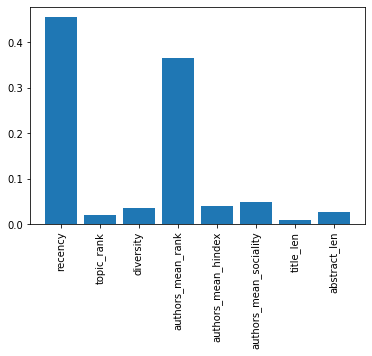

In [15]:
score, importances =  cv_pipeline(pub_df, default_params)
print(score)
plot_bar(importances)

Generate new features (based on previous data analisys and feature importances)

In [16]:
pub_df['fresh_and_actual'] = np.log(pub_df['recency'] + pub_df['topic_rank'])
pub_df['auth_author_and_fresh'] = np.log(pub_df['authors_mean_rank'] + pub_df['recency'])
# drop old feature
pub_df = pub_df.drop(['authors_mean_rank'], axis =1)

Score with generated features

0.8430999858942698


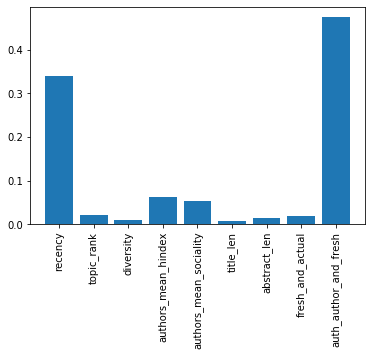

In [17]:
score, importances =  cv_pipeline(pub_df, default_params)
print(score)
plot_bar(importances)

feature selection (Recursive Feature Elimination)

In [18]:
def feature_selection(df, params):
    
    best_score = 0
    
    for _ in range(df.shape[1]-1):
        
        score, importances = cv_pipeline(df, params)
        if score>= best_score:
            less_imp_feature = min(importances, key = importances.get)
            print('score: {}, \n delete feature: {}'.format(score, less_imp_feature))
            df = df.drop([less_imp_feature], axis = 1)
            best_score = score
            best_importances = importances
        else:
            return best_score, best_importances
        
    return best_score, best_importances
            
        
        

Score with selected features

score: 0.8430999858942698, 
 delete feature: title_len
score: 0.8489119637996391, 
 delete feature: abstract_len
score: 0.8490796830593087, 
 delete feature: diversity
score: 0.8507290292491705, 
 delete feature: fresh_and_actual
0.8507290292491705


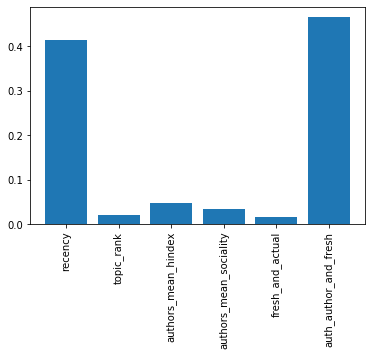

In [19]:
score, importances =  feature_selection(pub_df, default_params)

print(score)
plot_bar(importances)

Model tuning

In [20]:
params_grid = {'min_child_weight':[1,2,3],
          'gamma':[i/10.0 for i in range(0,7)],
          'max_depth': [3,4,5,6,7],
          'eta' : [i/20.0 for i in range(4,8)],
          'reg_alpha' : [1.5,2, 2.5,3]
         }

In [21]:
X = np.array(pub_df.loc[:, importances.keys()].values)
y = np.array(pub_df['c5'].values)

transformer = StandardScaler().fit(X)
X = transformer.transform(X)

regressor = xgb.XGBRegressor() 

grid = GridSearchCV(regressor, params_grid, cv = cv)
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=8, shuffle=True),
             error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    mi...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=None,
             param_grid={'eta': [0.2, 0.25, 0.

In [22]:
grid.best_params_

{'eta': 0.3,
 'gamma': 0.5,
 'max_depth': 6,
 'min_child_weight': 1,
 'reg_alpha': 2}

# Final score

In [23]:
cv_pipeline(pub_df.loc[:, [*importances.keys()] + ['c5']], grid.best_params_)

(0.8830090955339343,
 {'recency': 0.35134962,
  'topic_rank': 0.015220876,
  'authors_mean_hindex': 0.060827862,
  'authors_mean_sociality': 0.025594328,
  'fresh_and_actual': 0.019010726,
  'auth_author_and_fresh': 0.52799666})

# Conclusion

- data don't have heavy correlation between response and explanatory variables
- data contain a lot of insignificant features
- generated features, based on most important features significantly improve validation score for most of cases
- the most important features in initial data is "authors_mean_rank" and "recency" 